In [1]:
import SimpleITK as sitk
from subprocess import Popen
import subprocess
import SimpleITK as sitk
import pandas as pd
import multiprocessing as mp
import functools
from functools import partial
import sys
import os.path
from os import path as pathOs
import numpy as np
import tempfile
import shutil
from os.path import basename, dirname, exists, isdir, join, split
from pathlib import Path
import fileinput
import re
import subprocess
from toolz.itertoolz import groupby
import seaborn as sns
import einops
import matplotlib.pyplot as plt
import itertools
import SimpleITK as sitk
import mdai
import pandas as pd
import numpy as np
import cv2
import pydicom
import os
import multiprocessing as mp
import functools
from functools import partial
import mdai
import math
import time
import itertools
from pydicom.fileset import FileSet
from os import path as pathOs
from pathlib import Path
import toolz
from toolz.curried import pipe, map, filter, get
from toolz import curry
from os.path import basename, dirname, exists, isdir, join, split
import nnunetv2
import tempfile
import shutil
import re
from toolz.itertoolz import groupby
from toolz import curry
# import multiprocess
# p = multiprocess.Pool(os.cpu_count())
import multiprocessing as mp
import json
import os
from subprocess import Popen
import subprocess
from skimage.segmentation import mark_boundaries
from scipy import ndimage
import torch
import xformers.components.attention.attention_patterns as AP
from xformers.components.attention.core import scaled_dot_product_attention
from xformers.components.attention._sputnik_sparse import SparseCS
import xformers.components.attention.attention_patterns as AP
%matplotlib inline

<AxesSubplot:>

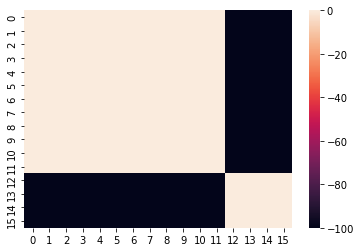

In [2]:


def window_partition(x, window_size):
    """window partition operation based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        x: input tensor.
        window_size: local window size.
    """
    x_shape = x.size()
    if len(x_shape) == 5:
        b, d, h, w, c = x_shape
        x = x.view(
            b,
            d // window_size[0],
            window_size[0],
            h // window_size[1],
            window_size[1],
            w // window_size[2],
            window_size[2],
            c,
        )
        windows = (
            x.permute(0, 1, 3, 5, 2, 4, 6, 7).contiguous().view(-1, window_size[0] * window_size[1] * window_size[2], c)
        )
    elif len(x_shape) == 4:
        b, h, w, c = x.shape
        x = x.view(b, h // window_size[0], window_size[0], w // window_size[1], window_size[1], c)
        windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0] * window_size[1], c)
    return windows

def compute_mask(dims, window_size, shift_size, device):
    """Computing region masks based on: "Liu et al.,
    Swin Transformer: Hierarchical Vision Transformer using Shifted Windows
    <https://arxiv.org/abs/2103.14030>"
    https://github.com/microsoft/Swin-Transformer

     Args:
        dims: dimension values.
        window_size: local window size.
        shift_size: shift size.
        device: device.
    """

    cnt = 0

    if len(dims) == 3:
        d, h, w = dims
        img_mask = torch.zeros((1, d, h, w, 1), device=device)
        for d in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for h in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                for w in slice(-window_size[2]), slice(-window_size[2], -shift_size[2]), slice(-shift_size[2], None):
                    img_mask[:, d, h, w, :] = cnt
                    cnt += 1
    elif len(dims) == 2:
        h, w = dims
        img_mask = torch.zeros((1, h, w, 1), device=device)
        for h in slice(-window_size[0]), slice(-window_size[0], -shift_size[0]), slice(-shift_size[0], None):
            for w in slice(-window_size[1]), slice(-window_size[1], -shift_size[1]), slice(-shift_size[1], None):
                img_mask[:, h, w, :] = cnt
                cnt += 1
    mask_windows = window_partition(img_mask, window_size)
    mask_windows = mask_windows.squeeze(-1)
    attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
    attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
    return attn_mask

dims=(8,8)
window_size=(4,4)
shift_size=(1,1)
device='cpu'
res=compute_mask(dims, window_size, shift_size, device)
res.shape
sns.heatmap(res[2,:,:].detach().cpu().numpy())

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


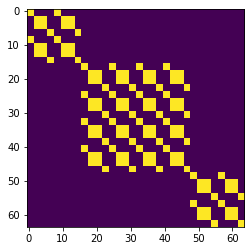

In [3]:
# generic nd cases
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)


def swin_attention_pattern(H, W, window_size, shift_size=0):
    assert H % window_size == 0
    assert W % window_size == 0
    assert 0 <= shift_size < window_size, "shift_size must in 0-window_size"

    # input grid
    i, j = _generate_nd_grid(H, W)
    i, j = i + 0.5, j + 0.5

    # anchors grid
    # if shift is present, add extra element to the grid
    # to account for the uneven partitioning
    extra = int(shift_size % window_size != 0)
    grid_h = H // window_size + extra
    grid_w = W // window_size + extra

    ii, jj = _generate_nd_grid(grid_h, grid_w)
    # convert shift to be compatible with the paper representation
    s = (-shift_size) % window_size
    offset = window_size / 2 - s
    ii = ii * window_size + offset
    jj = jj * window_size + offset

    input_coords = torch.stack([i.flatten(), j.flatten()], 1).float()
    anchors_coords = torch.stack([ii.flatten(), jj.flatten()], 1).float()

    anchor_id = torch.cdist(input_coords, anchors_coords, p=2).argmin(1)
    mask = anchor_id[:, None] == anchor_id[None, :]
    return mask

aa=swin_attention_pattern(8,8, 4, 2)
plt.imshow(aa)

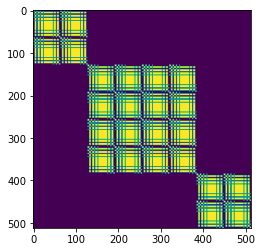

In [4]:

def swin_attention_pattern_3D(H, W,D, window_size, shift_size=0):
    assert H % window_size == 0
    assert W % window_size == 0
    assert D % window_size == 0
    assert 0 <= shift_size < window_size, "shift_size must in 0-window_size"

    # input grid
    i, j ,k = _generate_nd_grid(H, W,D)
    i, j ,k = i + 0.5, j + 0.5, k + 0.5

    # anchors grid
    # if shift is present, add extra element to the grid
    # to account for the uneven partitioning
    extra = int(shift_size % window_size != 0)
    grid_h = H // window_size + extra
    grid_w = W // window_size + extra
    grid_d = D // window_size + extra

    ii, jj ,kk= _generate_nd_grid(grid_h, grid_w,grid_d)
    # convert shift to be compatible with the paper representation
    s = (-shift_size) % window_size
    offset = window_size / 2 - s
    ii = ii * window_size + offset
    jj = jj * window_size + offset
    kk = kk * window_size + offset


    input_coords = torch.stack([i.flatten(), j.flatten(),k.flatten()], 1).float()
    anchors_coords = torch.stack([ii.flatten(), jj.flatten(),jj.flatten()], 1).float()

    anchor_id = torch.cdist(input_coords, anchors_coords, p=2).argmin(1)
    mask = anchor_id[:, None] == anchor_id[None, :]
    return mask
aa=swin_attention_pattern_3D(8,8,8, 4, 2)
plt.imshow(aa)

In [5]:
from xformers.factory import xFormer, xFormerConfig
from xformers.helpers.hierarchical_configs import (
    BasicLayerConfig,
    get_hierarchical_configuration,
)

In [68]:
def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)


def local_nd_distance(*sizes, p=2.0, weights=None):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    d = torch.cdist(grid, grid, p=p)
    return d

def local_nd_pattern(*sizes, distance, p=2.0):
    d = local_nd_distance(*sizes, p=p)
    # print(d)
    return d < distance


pat=local_nd_pattern(4,4,4,distance=1.5)
# plt.imshow(pat)
# d=local_nd_distance(6,6,6)
# plt.imshow(d)

attn_mask = SparseCS(pat, torch.device("cpu"))
attn_mask

In [71]:
        # csr_matrix = SparseCSRTensor._wrap(
        #     _shape, values, row_indices, row_offsets, column_indices, _transp_info
        # )
attn_mask.shape

torch.Size([64, 64])

In [74]:
from xformers.sparse import SparseCSRTensor

def _generate_nd_grid(*sizes):
    coords = [torch.arange(s) for s in sizes]
    return torch.meshgrid(*coords)


def local_nd_distance_parts(*sizes, p=2.0, weights=None,start=0,end=10):
    if weights is None:
        weights = (1,) * len(sizes)
    assert len(sizes) == len(weights)
    grid = _generate_nd_grid(*sizes)
    grid = [i.flatten() * w for i, w in zip(grid, weights)]
    grid = torch.stack(grid, dim=1).float()
    print(f"kkkk {grid.shape}")
    d = torch.cdist(grid, grid[start:end,:], p=p)
    return d

def local_nd_pattern(*sizes, distance, p=2.0,start=0,end=10):
    d = local_nd_distance_parts(*sizes, p=p
                                ,start=start
                                ,end=end)
    # print(d)
    return d < distance
part_1= SparseCS(local_nd_pattern(4,4,4,distance=1.5,start=0,end=32), torch.device("cpu"))
part_2= SparseCS(local_nd_pattern(4,4,4,distance=1.5,start=8,end=32), torch.device("cpu"))


fused=SparseCS.wrap(shape=(64,64)
              ,values= torch.cat([part_1.values,part_2.values],dim=-1)
              ,row_indices= torch.cat([part_1.row_indices,part_2.row_indices],dim=-1)
              ,row_offsets= torch.cat([part_2.row_offsets],dim=-1)#+part_1.row_offsets[-1]
              ,column_indices= torch.cat([part_1.column_indices,part_2.column_indices],dim=-1)
              ,_transp_info=(
                  torch.cat([part_1._transp_info[0],part_2._transp_info[0]],dim=-1)
                  ,torch.cat([part_1._transp_info[1],part_2._transp_info[1]],dim=-1)
                  ,torch.cat([part_1._transp_info[2],part_2._transp_info[2]],dim=-1)
                  ,torch.cat([part_1._transp_info[3],part_2._transp_info[3]],dim=-1)
                            )    )
# plt.imshow(pat)
# d=local_nd_distance(6,6,6)
# plt.imshow(d)

#torch.Size([1, 24, 24, 48, 40]) a torch.Size([1, 48, 12, 24, 20]) b  torch.Size([1, 96, 6, 12, 10])  

# attn_mask = SparseCS(pat, torch.device("cpu"))
print(f"orig {attn_mask.row_offsets}  fused {fused.row_offsets} orig {attn_mask.row_offsets.shape}  fused {fused.row_offsets.shape}  ")
torch.equal(attn_mask.row_offsets,fused.row_offsets)

kkkk torch.Size([64, 3])
kkkk torch.Size([64, 3])
orig tensor([  0,   7,  17,  27,  34,  44,  58,  72,  82,  92, 106, 120, 130, 137,
        147, 157, 164, 174, 188, 202, 212, 226, 245, 264, 278, 292, 311, 330,
        344, 354, 368, 382, 392, 402, 416, 430, 440, 454, 473, 492, 506, 520,
        539, 558, 572, 582, 596, 610, 620, 627, 637, 647, 654, 664, 678, 692,
        702, 712, 726, 740, 750, 757, 767, 777, 784], dtype=torch.int32)  fused tensor([  0,   3,   7,  11,  14,  20,  28,  36,  42,  50,  61,  72,  80,  87,
         97, 107, 114, 118, 124, 130, 134, 141, 151, 161, 168, 177, 190, 203,
        212, 219, 229, 239, 246, 249, 253, 257, 260, 264, 269, 274, 278, 282,
        287, 292, 296, 299, 303, 307, 308, 308, 308, 308, 308, 308, 308, 308,
        308, 308, 308, 308, 308, 308, 308, 308, 308], dtype=torch.int32) orig torch.Size([65])  fused torch.Size([65])  


False

In [77]:
import einops
np.arange(3*3*3).reshape((3,3,3))

array([[[ 0,  1,  2],
        [ 3,  4,  5],
        [ 6,  7,  8]],

       [[ 9, 10, 11],
        [12, 13, 14],
        [15, 16, 17]],

       [[18, 19, 20],
        [21, 22, 23],
        [24, 25, 26]]])

(23040, 3)
(23040, 23040)


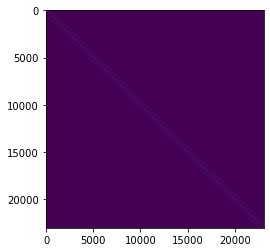

In [23]:

# import scipy

# def _generate_nd_grid(*sizes):
#     coords = [np.arange(s) for s in sizes]
#     return np.meshgrid(*coords)

# def local_nd_distance(*sizes, p=2.0, weights=None):
#     if weights is None:
#         weights = (1,) * len(sizes)
#     assert len(sizes) == len(weights)
#     grid = _generate_nd_grid(*sizes)
#     grid = [i.flatten() * w for i, w in zip(grid, weights)]
#     grid = np.stack(grid, axis=1)#.astype(float)
#     print(grid.shape)
#     d = scipy.spatial.distance.cdist(grid, grid, 'euclidean')
#     print(d.shape)
#     return d

# def local_nd_pattern(*sizes, distance, p=2.0):
#     d = local_nd_distance(*sizes, p=p)
#     # print(d)
#     return d < distance

# # patB=local_nd_pattern(24,96,80,distance=1.5)
# patB=local_nd_pattern(12,48,40,distance=1.5)
# plt.imshow(patB)

In [19]:
batch_size=1
img_size=(24,96,80)
# img_size=(16,16,16)
patch_size=(2,2,2)
i_layer=1
embed_dim=7

def get_image_size():
    p= patch_size
    res=[batch_size,embed_dim,img_size[0]/p[0],img_size[1]/p[1],img_size[2]/p[2]]
    for i in range(i_layer):
        res[1]=res[1]*2
        res[2]=int(res[2]//2)
        res[3]=int(res[3]//2)
        res[4]=int(res[4]//2)
    return res

get_image_size()


[1, 14, 6, 24, 20]

In [18]:
sizes=(16,16,16)
grid = _generate_nd_grid(*sizes)
weights = (1,) * len(sizes)
grid = [i.flatten() * w for i, w in zip(grid, weights)]
grid = np.stack(grid, axis=1)#.astype(float)
grid

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [15, 15, 13],
       [15, 15, 14],
       [15, 15, 15]])

In [84]:
sizes=(3,3,3)
grid = _generate_nd_grid(*sizes)
grid = [i.flatten() * w for i, w in zip(grid, weights)]
grid = torch.stack(grid, dim=1).float()
res=einops.rearrange(grid,'(x y z) p->x y z p',x=3,y=3,z=3)
# grid.shape $ torch.Size([27, 3])
res[0,2,0]

tensor([0., 2., 0.])